In [1]:
import os
import re
import requests
import zipfile
import plotly.express as px
from matplotlib import pyplot as plt

import nltk


from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import numpy as np
import seaborn as sns
import pandas as pd
from collections import Counter
from typing import Callable

%matplotlib inline

In [2]:
nltk.download("popular")

[nltk_data] Error loading popular: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

# Introduction

The goal of this notebook is to *practice text preprocessing*


You're part of a team in Twitter that's assigned to create a sentiment analysis model for tweets in Arabic, your task is to prepare the data for training a model to classify wether the tweet has *positive* or *negative* sentiment

## Components of Preprocessing

### Text Cleaning

We need to remove or keep parts of the tweet so that the remaining text is **relevant** to the task at hand 

#### What are the possbile parts to remove or keep?

1. Hashtags
2. Mentions
3. Emojis
4. URLs
5. Numbers
6. English characters
7. Stop words
8. Diactrics
9. Punctiation marks
10. Others

### Stemming / Lemmatisation



### Steps
In this notebook we should:

1. Read the raw data
2. Explore the dataset
3. Text Cleaning
4. Stemming / Lemmatisation

## The Dataset

The dataset for this project is ArSenTD-Lev, a collection of 4,000 labeled tweets in the Levantine dialect, along side the tweet text:

- Country
- Topic (personal, politics, religion, sports, entertainment, others)
- Sentiment (very_negative, negative, neutral, positive, very_positive)
- Sentiment_Expression : implicit, explicit, or none (when neutral)
- Sentiment_Target: The part of the text of which the sentiment was derived

The original dataset is found on the [original website](http://oma-project.com/ArSenL/ArSenTD_Lev_Intro)

and with another copy of the dataset found on the [course website](https://shai-nlp-course.netlify.app/ArSenTD-LEV.tsv)

# Setup

In [3]:
data_dir = os.path.join(os.curdir, "data")
archive_path = os.path.join(data_dir, "ArSenTD-LEV.zip")
tweets_dir = os.path.join(data_dir, "ArSenTD-LEV")

## Download Raw Data



In [4]:
link = "http://oma-project.com/ArSenL/ArSenTD-LEV.zip"

response = requests.get(link)

with open(archive_path, "wb+") as f:
    f.write(response.content)
    
with zipfile.ZipFile(archive_path, 'r') as zip_f:
    zip_f.extractall(tweets_dir)


os.listdir(tweets_dir)

['ArSenTD-LEV.tsv', 'README.txt']

In [5]:
raw_filepath = os.path.join(tweets_dir, "ArSenTD-LEV.tsv")

In [6]:
raw = pd.read_csv(filepath_or_buffer=raw_filepath, sep="\t", encoding="utf_8")

In [7]:
raw.head()

,Tweet,Country,Topic,Sentiment,Sentiment_Expression,Sentiment_Target
0,"""أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد م...",lebanon,personal,negative,implicit,بريق العيون
1,من الذاكره... @3FInQe . عندما اعتقد كريستيانو ...,jordan,sports,positive,explicit,افضل لاعب في العالم
2,لا نخلو من ضغوطات الحياة. فنحن نعيش على أرض أع...,palestine,personal,neutral,none,none
3,#مصطلحات_لبنانيه_حيرت_البشريه بتوصل عالبيت ، ب...,lebanon,personal,negative,explicit,مصطلحات_لبنانيه
4,نصمت !! لتسير حياتنا على مً يرام فالناّس لم تع...,palestine,personal,negative,explicit,س لم تعد كما ك


# Explaratory Data Analysis (EDA)

In [8]:
data = raw.copy(deep=True)

In [9]:
data["Sentiment"] = data["Sentiment"].replace(
    {"very_negative": "negative", "very_positive": "positive"}
)

In [10]:
px.pie(data,names='Sentiment')

### Common EDA Patterns Text

- Check for word count
- Check for character count

In [11]:
# Count words for each tweet
data["word_count"] = data["Tweet"].apply(lambda x: len(x.split(" ")))

In [12]:
data["word_count"].describe()

count    4000.00000
mean       22.69825
std         3.28495
min         7.00000
25%        21.00000
50%        23.00000
75%        25.00000
max        35.00000
Name: word_count, dtype: float64

In [13]:
# Count nums of chrc for each tweet
data["char_count"] = data["Tweet"].apply(len)
data["char_count"].describe()

count    4000.000000
mean      131.364250
std        14.314636
min        42.000000
25%       128.000000
50%       138.000000
75%       140.000000
max       147.000000
Name: char_count, dtype: float64

In [14]:
px.histogram(data, x="word_count",title='word_count',color_discrete_sequence=['indianred'] )


In [15]:
px.histogram(data, x="char_count",title='char_count',color_discrete_sequence=['aquamarine'] )


## Vocabulary

Vocabulary: the set of unique vocabulary in the corpus
and optionally the count of each vocab

In [16]:
all_words = [word for tweet in data["Tweet"] for word in tweet.split(" ")]

In [17]:
vocab = Counter(all_words)

Explore the most and least common words in the vocab

In [18]:
print("Least Common")
vocab.most_common()[-10:]

Least Common


[('الريحة', 1),
 ('نقلاً', 1),
 ('مباشراً', 1),
 ('نشرة', 1),
 ('الرياضية', 1),
 ('8:30', 1),
 ('"العرب"', 1),
 ('حمود', 1),
 ('📍', 1),
 ('https://t.co/oUstA9G7dM', 1)]

In [19]:
print("Most Common")
vocab.most_common(n=10)

Most Common


[('من', 1906),
 ('في', 1610),
 ('.', 1105),
 ('و', 963),
 ('على', 913),
 ('الله', 787),
 ('ما', 769),
 ('لا', 656),
 ('،', 589),
 ('كل', 493)]

In [20]:
counts = list(vocab.values())

In [21]:
data['temp_list'] = data['Tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(90))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')


,Common_words,count
0,من,1906
1,في,1610
2,.,1105
3,و,963
4,على,913
5,الله,787
6,ما,769
7,لا,656
8,،,589
9,كل,493


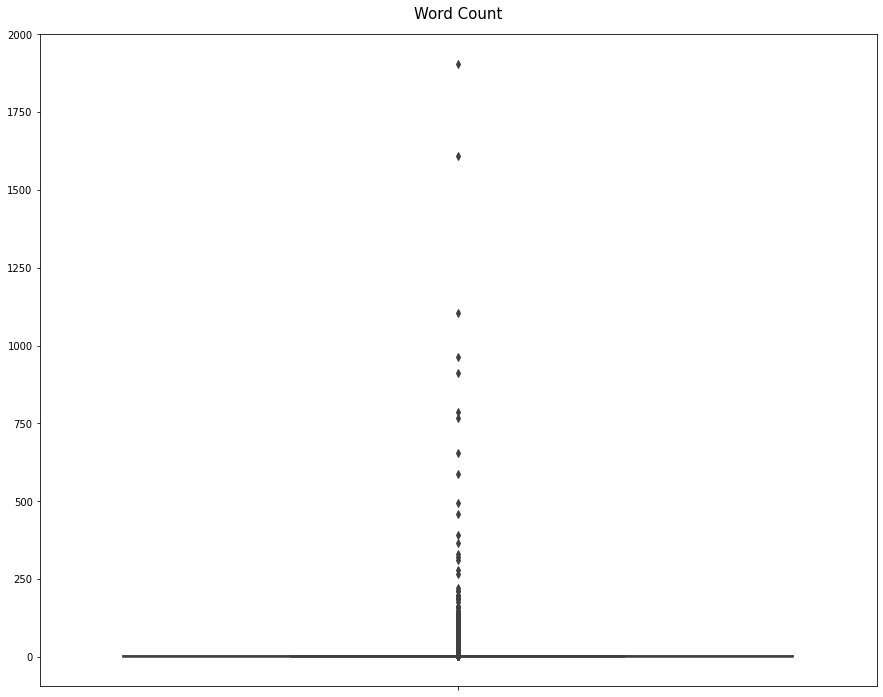

In [22]:
fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(y=counts, ax=ax)
ax.set_title("Word Count", fontdict=dict(size=15), pad=15)

plt.show()

In [23]:
fig = px.bar(temp[:20], x='Common_words', y='count', title='Counts of top unigram before removing stop words', template='plotly_white', labels={'ngram': 'unigrams', 'count': 'Count'})
fig.show()

In [24]:
stop_words = stopwords.words("arabic")
all_words_pruned = [word for tweet in data["Tweet"] for word in tweet.split(" ") if word not in stop_words]

In [25]:
pruned_vocab = Counter(all_words_pruned) 

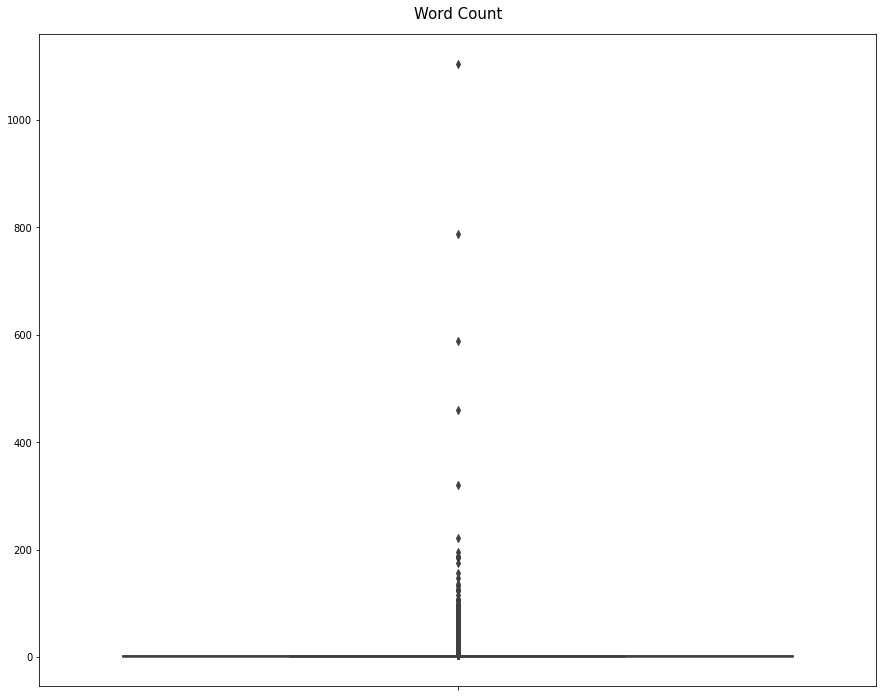

In [26]:
counts = list(pruned_vocab.values())

fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(y=counts, ax=ax)
ax.set_title("Word Count", fontdict=dict(size=15), pad=15)

plt.show()

> Removing stop words still produces a box plot with this many outliers indicates that more cleaning is necessary

# Text Cleaning

let's take sample frome data to check our cleaning

In [27]:
sample = data.iloc[102]["Tweet"]
sample

'هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA'

In [28]:
def test_clean_fn(fn: Callable, sample: str) -> str:
    print(sample, fn(sample), sep="\n")

## Stop Words

In [29]:
stop_words

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [30]:
list(temp.Common_words.values[:100])

['من',
 'في',
 '.',
 'و',
 'على',
 'الله',
 'ما',
 'لا',
 '،',
 'كل',
 '..',
 'عن',
 'يا',
 'مع',
 'ان',
 'أن',
 'ولا',
 'بس',
 'الى',
 'بعد',
 'هو',
 'هذا',
 'بن',
 ':',
 'لبنان',
 '-',
 '...',
 'كان',
 'لو',
 'اللهم',
 'إلى',
 'او',
 'الذي',
 'انت',
 'حتى',
 'التي',
 'اللي',
 'ع',
 'انا',
 'مش',
 'الحريري',
 'هي',
 'لم',
 'هل',
 'اليوم',
 'عليه',
 'أو',
 'لك',
 'السعودية',
 'الي',
 'بين',
 'عم',
 'قبل',
 'كانت',
 'والله',
 'غير',
 'عندما',
 '؟',
 'لي',
 '!',
 'هذه',
 'يوم',
 'يكون',
 'اذا',
 'له',
 'إلا',
 'قال',
 'كنت',
 'حزب',
 'الا',
 'محمد',
 'واحد',
 'شي',
 'شو',
 'سلمان',
 'لن',
 'الناس',
 'أنت',
 'انو',
 'يعني',
 'سعد',
 'إن',
 'كيف',
 'الرئيس',
 'انه',
 '"',
 'قد',
 'رئيس',
 'اي',
 'العالم']

In [64]:
stop_words=stop_words+list(temp.Common_words.values[:100])+['ان','الى','او','انت']

In [65]:
'ان' in stop_words

True

In [32]:
stop_words= stopwords.words("arabic")+list(temp.Common_words.values[:100])+['ان','الى','او','انت']
to_keep = ["لا","السعودية","الرئيس","الحريري","سعد","لبنان","العراق","سوريا","يارب"]

stop_words = [word for word in stop_words if word not in to_keep] 

def remove_stop_words(text: str) -> str:
    return " ".join([word for word in text.split(" ") if word not in stop_words])


test_clean_fn(remove_stop_words, sample)

هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA
هدف لا نراه يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA


## Remove Hashtags

[Regex to remove hashtag](https://regexr.com/3gkpo)

In [33]:
hashtag_re = re.compile(pattern="#[A-z0-9_ا-ي]+")

def remove_hashtag(text: str) -> str:
    return hashtag_re.sub(repl="", string=text)

test_clean_fn(remove_hashtag, sample)

هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA
هدف لا نراه كل يوم .  . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA


## Remove Mention

In [34]:
def remove_mention(text: str) -> str:
    # TODO: Look for a suitable way to remove mentions from a text
    # TIP: Look for a regex expression
    return re.sub(pattern=r"@[^\s]+", repl="", string=text)
    
test_clean_fn(remove_mention, sample)

هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA
هدف لا نراه كل يوم . #LEITOT .  شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA


## Remove Punctuation Marks

In [35]:
def remove_punctation(text: str) -> str:
    # TODO: Look for a suitable way to remove punctiation marks from a text
    # TIP: Look for a regex expression
    return re.sub(pattern=r"[\W\s_]+", repl=" ", string=text)
    
test_clean_fn(remove_punctation, sample)

هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA
هدف لا نراه كل يوم LEITOT oki q8e شوف ابن اختي شوف https t co ZmVMl4sOqA


## Remove HTTP URLs

In [36]:
def remove_urls(text: str) -> str:
    # TODO: Look for a suitable way to remove urls from a text
    # TIP: Look for a regex expression
    return re.sub(r'http\S+', '', text)
    
test_clean_fn(remove_urls, sample)

هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA
هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 


## Remove Diactrics

In [37]:
diactircs_re = re.compile("[\u064B-\u0652]")

def remove_diactrics(text: str) -> str:
    # TODO: Implement this function using the diactrics_re
    
    return  re.sub(diactircs_re, '', str(text))
    
test_clean_fn(remove_diactrics, data.iloc[0]["Tweet"])

"أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد من يحب ، حتى بريق العيون يختفي فيصبح ذابلاً منطفئًا، يتحول ربيعه الى خريف.". @gbraniiat
"أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد من يحب ، حتى بريق العيون يختفي فيصبح ذابلا منطفئا، يتحول ربيعه الى خريف.". @gbraniiat


## Remove Numbers

In [38]:
def remove_numbers(text: str) -> str:
    # TODO: Implement remove numbers
    return re.sub(r"\d+\W+|\W+\d+", "", text)
    
test_clean_fn(remove_numbers, data.iloc[65]["Tweet"])

@GundiOmer @WahidBarzane 6- برامج واجندات لسب جميع صحابة رسول الله صل الله عليه وسلم 7- تدمير منطقة الشرق الاوسط و… https://t.co/Mey9HB1979
@GundiOmer @WahidBarzane- برامج واجندات لسب جميع صحابة رسول الله صل الله عليه وسلم- تدمير منطقة الشرق الاوسط و… https://t.co/Mey9HB1979


## Remove English Characters

In [39]:
def remove_english_characters(text: str) -> str:
    # TODO: Implement remove english characters
    
    return re.sub(r'[A-z]', '', text)


In [40]:
[word for word, word_count in vocab.most_common()[-10:]]


['الريحة',
 'نقلاً',
 'مباشراً',
 'نشرة',
 'الرياضية',
 '8:30',
 '"العرب"',
 'حمود',
 '📍',
 'https://t.co/oUstA9G7dM']

## Remove Most and Least Common Words

In [41]:
## TODO: define a list of least occurent words
rare_words = []
common_words = []

def remove_rare_words(text: str) -> str:
    rare_words.append([word for word, word_count in vocab.most_common()[-10:]])
    return  " ".join([word for word in text.split(" ") if word not in rare_words])

# def remove_common_words(text: str) -> str:
# i have deleted before common words with stop words

## Reduce Multiple Whitespace 

In [42]:
multiple_space_re = re.compile("\s{2,}")
def remove_multiple_whitespace(text: str) -> str:
    return re.sub(multiple_space_re,repl=" ", string=str(text))
#text = re.sub("(\s+)"," ",text)

## Clean All

In [66]:
def clean_all(text: str) -> str:
    text = remove_urls(text)
    text = remove_hashtag(text)
    text = remove_mention(text)
    text = remove_punctation(text)
    text = remove_numbers(text)
    text = remove_diactrics(text)
    text = remove_english_characters(text)
    text = remove_stop_words(text)
#     text = remove_common_words(text)
    text = remove_rare_words(text)
    text = remove_multiple_whitespace(text)
    return text

In [67]:
data["clean_text"] = data["Tweet"].apply(clean_all)

# is Right to do it like this with apply ?
I face some Errors with cleaning stop words , normalize some arabic charachters 


In [ ]:
arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [3]:
def data_preprocessing(df):
    df['Tweet_Clean'] = df['Tweet'].apply(lambda x: re.sub(r'@[^\s]+', '', x)) #remove mentions
    df['Tweet_Clean'] = df ['Tweet'].apply(lambda x: re. sub(r"http\S+", ' ', x)) #remove links
     df['Tweet_Clean'] = df ['Tweet'].apply(lambda x: re. sub(r"#[A-z0-9_ا-ي]+", ' ', x)) #remove hashtag
    df['Tweet_Clean'] = df [ 'Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (arabic_stop_words)])) #remove stop words
    df['Tweet_Clean'] =  df ['Tweet'].apply(lambda i: ' '.join(filter(lambda j: len(j) > 3, i.split())))     #delete every tweet with length less than 3                                       
    df['Tweet_Clean']=df['Tweet'].apply(lambda x:ISRIStemmer().stem(x)) #stemmer

    df['Tweet_Clean']=df['Tweet'].apply(lambda x: re.sub(arabic_diacritics, "",x)) 
    df['Tweet_Clean']=df['Tweet'].replace("آ", "ا") 
    df['Tweet_Clean']=df['Tweet'].replace("إ", "ا") 
    df['Tweet_Clean']=df['Tweet']replace("أ", "ا") 
    df['Tweet_Clean']=df['Tweet'].replace("ؤ", "و") 
    df['Tweet_Clean']=df['Tweet'].replace("ئ", "ي")
    df['Tweet_Clean']=df['Tweet'].apply(lambda x: re. sub(r"[^ا-ي]", ' ', x)) 
    return df


# and I face errors with normalize sub ("آ", "ا") and "إ", "ا") ,, etc and i don't know why it didn't work , hope you help me . with respect :)


In [ ]:
def data_cleaning (text):
    text = re.sub(r"\d+\W+|\W+\d+|\s\d+|\d+", "", text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = re.sub(r'(.)\1+', r'\1', text) #remove duplication charchters
    text = text.replace("آ", "ا")
    text = text.replace("إ", "ا")
    text = text.replace("أ", "ا")
    text = text.replace("ؤ", "و")
    text = text.replace("ئ", "ي")
    text = re. sub(r"[^ا-ي]", ' ', text)
    text = re.sub("(\s+)"," ",text) # remove multiwhitespace with one whitespace
    
    
    
    return text
data['Tweet_clean']=data['Tweet'].apply(lambda x: data_cleaning(x))
data=data_preprocessing(data)

#   when I apply text.replace not dataframe.column.apply ==>  ("آ", "ا") and("ؤ", "و") etc here it work 

# Text Normalisation

In [68]:
# https://www.nltk.org/_modules/nltk/stem/isri.html

stemmer = ISRIStemmer()

In [69]:
stemmer.stem("يذهبون")

'ذهب'

In [70]:
stemmed_data = []
for sample in data["clean_text"]:
    words = sample.split(" ")
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_data.append(" ".join(stemmed_words))



In [71]:
print(data["clean_text"][0], stemmed_data[0])

 أؤمن بأن الانسان ينطفئ جماله ابتعاد يحب بريق العيون يختفي فيصبح ذابلا منطفئ يتحول ربيعه خريف   اؤم بأن انس طفئ جمل بعد يحب برق عين خفي صبح ذبل طفئ تحل ربع خرف 


In [72]:
data["clean_stemmed"] = stemmed_data

In [73]:
data

,Tweet,Country,Topic,Sentiment,Sentiment_Expression,Sentiment_Target,word_count,char_count,temp_list,clean_text,clean_stemmed
0,"""أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد م...",lebanon,personal,negative,implicit,بريق العيون,23,132,"[""أنا, أؤمن, بأن, الانسان, ينطفئ, جماله, عند, ...",أؤمن بأن الانسان ينطفئ جماله ابتعاد يحب بريق ...,اؤم بأن انس طفئ جمل بعد يحب برق عين خفي صبح ذ...
1,من الذاكره... @3FInQe . عندما اعتقد كريستيانو ...,jordan,sports,positive,explicit,افضل لاعب في العالم,23,141,"[من, الذاكره..., @3FInQe, ., عندما, اعتقد, كري...",الذاكره اعتقد كريستيانو افضل لاعب كاكا ميسي ثا...,ذكر عقد كريستيانو فضل لعب ككا يسي ثلث حدث عكس
2,لا نخلو من ضغوطات الحياة. فنحن نعيش على أرض أع...,palestine,personal,neutral,none,none,24,133,"[لا, نخلو, من, ضغوطات, الحياة., فنحن, نعيش, عل...",نخلو ضغوطات الحياة فنحن نعيش أرض أعدت للبلاء و...,خلو ضغط حية فنح نعش ارض اعد بلء ولم سلم بيء وك...
3,#مصطلحات_لبنانيه_حيرت_البشريه بتوصل عالبيت ، ب...,lebanon,personal,negative,explicit,مصطلحات_لبنانيه,23,135,"[#مصطلحات_لبنانيه_حيرت_البشريه, بتوصل, عالبيت,...",بتوصل عالبيت بنط بقلك جيت بتقعد لتتحدث معو بق...,وصل علب بنط بقل جيت قعد حدث معو بقل تقم تمش ب...
4,نصمت !! لتسير حياتنا على مً يرام فالناّس لم تع...,palestine,personal,negative,explicit,س لم تعد كما ك,16,67,"[نصمت, !!, لتسير, حياتنا, على, مً, يرام, فالنا...",نصمت لتسير حياتنا يرام فالنا تعد كآنت نقيه,نصم تسر حيت يرم فال تعد كآن نقه
...,...,...,...,...,...,...,...,...,...,...,...
3995,صلاح من لاعب في المقاولون العرب يحلم ان يلعب ل...,lebanon,sports,positive,explicit,بطل قومي,27,133,"[صلاح, من, لاعب, في, المقاولون, العرب, يحلم, ا...",صلاح لاعب المقاولون العرب يحلم يلعب للاهلي وال...,صلح لعب قال عرب حلم لعب اهل زمل رفض لعب ربل رو...
3996,الملك سلمان بن عبد العزيز: تطبيق الأنظمة بحزم ...,lebanon,politics,positive,explicit,أساء استغلال السلطة والنفوذ,25,133,"[الملك, سلمان, بن, عبد, العزيز:, تطبيق, الأنظم...",الملك عبد العزيز تطبيق الأنظمة بحزم تطاول الما...,ملك عبد عزز طبق نظم حزم طول مال عام ولم حفظ خل...
3997,@ZahraaIraq9 😂 كل ما ادخل حسابي الكه تغريداتج ...,jordan,personal,negative,explicit,تغريداتج عن حب العراق,25,140,"[@ZahraaIraq9, 😂, كل, ما, ادخل, حسابي, الكه, ت...",ادخل حسابي الكه تغريداتج حب العراق وانتي هسه ...,دخل حسب الك تغريداتج حب عرق ونت هسه نطج جنس م...
3998,شو هالشعب نحنا اللي عايش بلا مي وكهربا والزبال...,lebanon,politics,negative,explicit,عايش بلا مي وكهربا,24,126,"[شو, هالشعب, نحنا, اللي, عايش, بلا, مي, وكهربا...",هالشعب نحنا عايش بلا مي وكهربا والزبالة والمجا...,هالشعب نحن عيش بلا مي كهرب زبل مجارير فيت عا ي...


# Post Processsing Exploration

In [74]:
# TODO: Plot a box plot of the remaining unique tokens
all_words = [word for tweet in data["clean_text"] for word in tweet.split(" ")]
vocab = Counter(all_words)
counts_after_cleaniing = list(vocab.values())

In [75]:
vocab.most_common(10)


[('', 4039),
 ('ال', 113),
 ('الحياة', 91),
 ('شيء', 76),
 ('تكون', 74),
 ('خير', 74),
 ('السلام', 71),
 ('العراق', 69),
 ('يارب', 67),
 ('رح', 66)]

## Is right to remove this "" space? i feel confuesed 

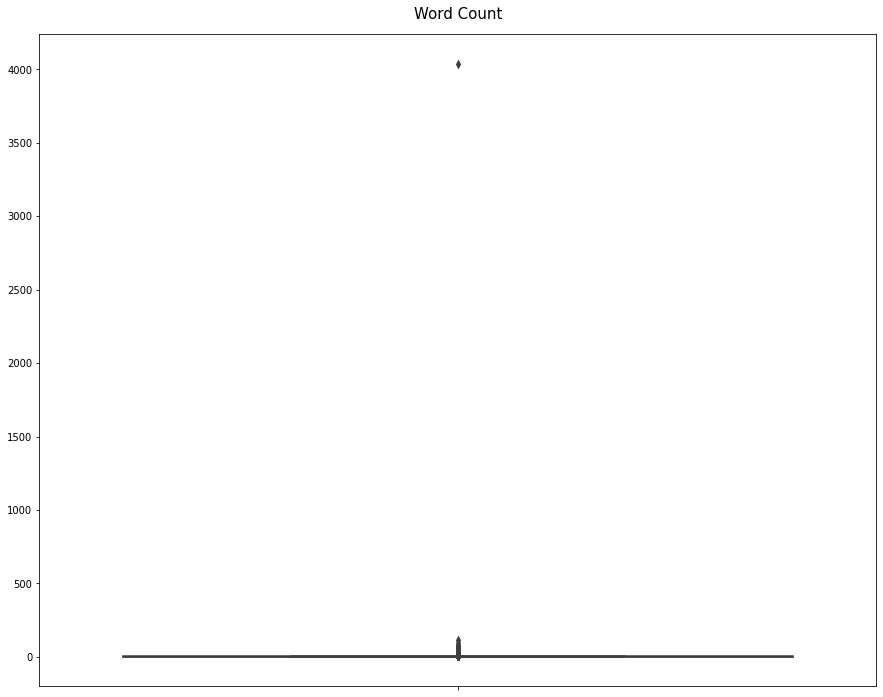

In [76]:


fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(y=counts_after_cleaniing, ax=ax)
ax.set_title("Word Count", fontdict=dict(size=15), pad=15)

plt.show()

# Save New Data

In [78]:
data_dir = os.path.join(os.curdir, "data")
filepath = os.path.join(data_dir, "clean-tweets.tsv")

data.to_csv(path_or_buf=filepath, sep="\t", index=False)